In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

import itertools, torch, os
import numpy as np
state_dir = #The path where the experiments took place, it is the same state_dir as in run_<type>.py

In [2]:
#util function
def get_name(model):
    model = model.replace('fbeta', 'Fbeta')
    model = model.replace('mihash', 'MIHash')
    model = model.replace('hashnet', 'HashNet')
    model = model.replace('shared_', 'Shared-')
    return model

def avg_if_enough(values, minimum_for_avg):
    values = np.array(values)
    notnan = ~np.isnan(values)
    return values[notnan].mean() if notnan.sum() >= minimum_for_avg else np.inf

def batch_avg_if_enough(values, minimum_for_avg):
    return np.array([avg_if_enough(v, minimum_for_avg) for v in values])

def show_hamming_bar(show, batch_ids=None):
    if batch_ids is None: batch_ids = [-1 for _ in range(len(show))]
    fig = plt.figure(figsize=(16,4*len(show)))
    for n, (model, i) in enumerate(zip(show, batch_ids)):
        ax = fig.add_subplot(len(show),1,n+1)
        sswr = avg_if_enough(results[model]['valid_5001mb_sswrs'][i], 100)
        ax.set_title('{} [HMBS-SSWR={:.4f}]'.format(model[:-1], sswr))
        pc = results[model]['valid_pos_counts'][i]
        nc = results[model]['valid_neg_counts'][i]
        plt.bar(range(65), pc/sum(pc), alpha=.8)
        plt.bar(range(65), nc/sum(nc), alpha=.8)

In [3]:
model_types = [
    'fbeta',
    'mihash',
    'hashnet',
    'shared_fbeta',
    'shared_mihash',
    'shared_hashnet',
]
all_models = [t+str(i) for t in model_types for i in range(5)]
all_fbeta = all_models[:5]
all_mihash = all_models[5:10]
all_hashnet = all_models[10:15]
all_shared_fbeta = all_models[15:20]
all_shared_mihash = all_models[20:25]
all_shared_hashnet = all_models[25:30]

In [4]:
path = os.path.join(state_dir, 'current/{}')
results = {
    name: torch.load(path.format(name), map_location=torch.device('cpu'))['results']
    for name in all_models
}
opt_hr_batch = {
    name: np.argsort(batch_avg_if_enough(results[name]['valid_2081hr_sswrs'], 100))[:5]
    for name in all_models
}
opt_mb_batch = {
    name: np.argsort(batch_avg_if_enough(results[name]['valid_5001mb_sswrs'], 100))[:5]
    for name in all_models
}

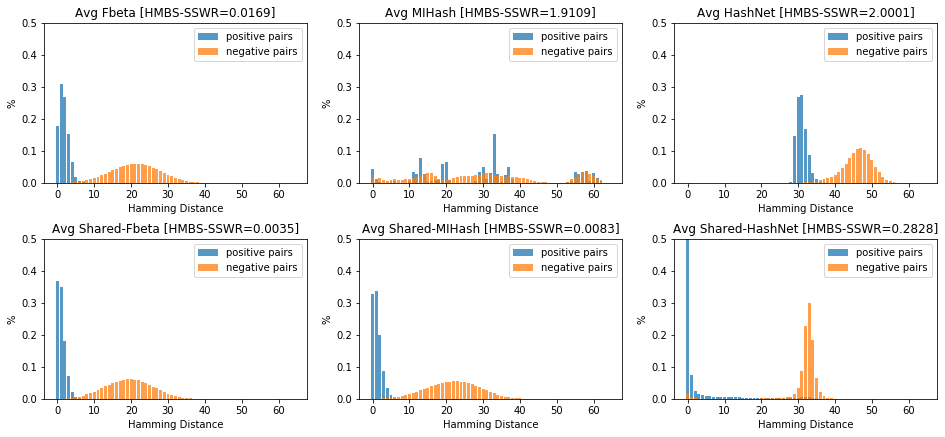

In [5]:
fig = plt.figure(figsize=(16,1*len(model_types)))
fig.subplots_adjust(top = 0.95, bottom=0.08, hspace=0.35, wspace=0.2)
for n, t in enumerate(model_types):
    sswrs = np.zeros((5,5))
    pcs = np.zeros((5,5,65))
    ncs = np.zeros((5,5,65))
    for i,j in itertools.product(range(5),range(5)):
        model = t+str(i)
        #take the last for hashnet since it has a constant HMBS-SSWR
        k = -1 if t=='hashnet' else opt_mb_batch[model][j]
        sswrs[i,j] = avg_if_enough(results[model]['valid_5001mb_sswrs'][k], 2)
        pcs[i,j] = results[model]['valid_pos_counts'][k]
        ncs[i,j] = results[model]['valid_neg_counts'][k]
    ax = fig.add_subplot(len(model_types)//3,3,n+1)
    sswr = sswrs.mean()
    ax.set_title('Avg {} [HMBS-SSWR={:.4f}]'.format(get_name(model[:-1]), sswr))
    pc = pcs.mean(axis=(0,1))
    nc = ncs.mean(axis=(0,1))
    ax.bar(range(65), pc/sum(pc), alpha=.75, label='positive pairs')
    ax.bar(range(65), nc/sum(nc), alpha=.75, label='negative pairs')
    ax.set_ylim(0,.5)
    ax.set_xlabel('Hamming Distance')
    ax.set_ylabel('%')
    ax.legend()
fig.savefig('hamming_histogram.png', dpi=300, bbox_inches='tight')

In [6]:
import pickle
#mbcrunch.pkl produced by the SSWRCrunhing Jupyter notebook
with open('mbcrunch.pkl', 'rb') as f:
    data = pickle.load(f)
    batchs, sswrs, sswrs_std, halts, halts_std = data

std: [0.12590604 0.03742703 0.08636762 0.68378157]


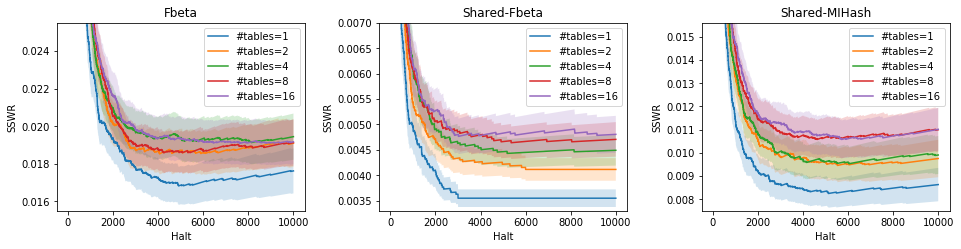

In [7]:
model_crunch_mapping = {
    'fbeta': 0,
    'shared_fbeta':1,
    'shared_mihash':2,
    'shared_hashnet':3,
}

#the ylim needs to be changed for other experiments
model_ylim = {
    'fbeta': (0.0155, 0.0255),
    'shared_fbeta':(0.0033, 0.007),
    'shared_mihash':(0.0075, 0.0156),
    'shared_hashnet':(0.1, 0.85),
}

show = ['fbeta', 'shared_fbeta', 'shared_mihash']
fig = plt.figure(figsize=(16, 3))
fig.subplots_adjust(top = 0.95, bottom=0.08, hspace=0.35, wspace=0.3)

ntables = [1,2,4,8,16]
for k, model in enumerate(show,1):
    ax = fig.add_subplot(1,3,k)
    n = model_crunch_mapping[model]
    for i in range(len(ntables)):
        c = sswrs[n, i]
        delta = .01*sswrs_std[n, i]
        ax.plot(c, label='#tables={}'.format(ntables[i]))
        ax.fill_between(range(10001), c-delta, c+delta, alpha=0.2)
    ax.set_ylim(*model_ylim[model])
    ax.legend()
    ax.set_title(get_name(model))
    ax.set_xlabel('Halt')
    ax.set_ylabel('SSWR')
fig.savefig('halt_curves.png', dpi=300, bbox_inches='tight')
print('std: {}'.format(sswrs_std.mean(axis=(1,2))))

In [8]:
%%capture 
#%%capture for no cell output

#show the evolution of the model0 of each type
show = all_models[::5]
frames = min([len(results[model]['valid_pos_counts']) for model in show])

fig = plt.figure(figsize=(14,4*len(show)))
fig.subplots_adjust(top = 0.95, bottom=0.08, hspace=0.35, wspace=0.3)
bars = list()
for n, model in enumerate(show):
    ax = fig.add_subplot(len(show),1,n+1)
    ax.set_title(get_name(model))
    ax.set_ylim((0, 1))
    pc = results[model]['valid_pos_counts'][0]
    nc = results[model]['valid_neg_counts'][0]
    bars += [(model, 'valid_pos_counts', plt.bar(range(65), pc/sum(pc), alpha=.8, label='positive pairs'))]
    bars += [(model, 'valid_neg_counts', plt.bar(range(65), nc/sum(nc), alpha=.8, label='negative pairs'))]
    ax.set_title(get_name(model))
    ax.set_xlabel('Hamming Distance')
    ax.set_ylabel('Probability')

def animate(i):
    for model, name, bar in bars:
        y = results[model][name][i]
        y = y / sum(y)
        for j, b in enumerate(bar):
            b.set_height(y[j])
    return [b[2] for b in bars]

anim = animation.FuncAnimation(fig,animate,repeat=False,blit=False,frames=frames,interval=1000)

In [9]:
HTML(anim.to_html5_video())